In [1]:
from sklearn import datasets
import warnings
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from autocluster.autohypothesis import autohypothesis_utils

In [2]:
from anchor import anchor_tabular

In [3]:
sk_wine = datasets.load_wine()
wine = pd.DataFrame(sk_wine['data'], columns=sk_wine['feature_names']).rename(columns={"od280/od315_of_diluted_wines":"od280_od315_of_diluted_wines"})
wine['target'] = sk_wine['target']

In [4]:
wine

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280_od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [5]:
# Test
synthetic_df = autohypothesis_utils.create_dataset(n=10, k=500, c=3, b=4)
exp,X_train, X_dev, y_train, y_dev  = autohypothesis_utils.opti_loop(wine,500, optimize_obj="dual")

[I 2024-05-13 11:03:09,810] A new study created in memory with name: no-name-c7ec24f9-4b1d-49b6-9d1a-2a0d21605a09
[I 2024-05-13 11:03:10,337] Trial 0 finished with values: [0.3888888888888889, 0.0] and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 730, 'rf_max_depth': 29, 'rf_min_samples_split': 0.642016697461591, 'rf_min_samples_leaf': 0.46761264208310405, 'rf_max_features': 'sqrt', 'rf_random_state': 42}. 
[I 2024-05-13 11:03:11,161] Trial 1 finished with values: [0.9814814814814815, 0.2621287601752289] and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 790, 'rf_max_depth': 19, 'rf_min_samples_split': 0.512727021899295, 'rf_min_samples_leaf': 0.06994179832865524, 'rf_max_features': 'log2', 'rf_random_state': 42}. 
[I 2024-05-13 11:03:12,010] Trial 2 finished with values: [0.3888888888888889, 0.0] and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 680, 'rf_max_depth': 4, 'rf_min_samples_split': 0.721623750346586, 'rf_min_samples_leaf': 0.4

In [6]:
fig = optuna.visualization.plot_pareto_front(exp, target_names=["Accuracy", "Entropie"], include_dominated_trials=False)
#fig = optuna.visualization.plot_pareto_front(motpe_experiment, target_names=["objective 1", "objective 2"])
fig.layout.title = 'Pareto-front MOTPE'
fig

In [7]:
all_objectives = np.array([trial.values for trial in exp.best_trials ])
#all_objectives = np.unique(all_objectives, axis=0)
sorted_objectives = all_objectives[np.argsort(all_objectives[:, 0])]
spread = np.mean(np.sqrt(np.sum(np.diff(sorted_objectives, axis=0)**2, axis=1)))
# Uniformité
uniformity = np.mean(np.std(np.diff(sorted_objectives, axis=0), axis=0))

# Taille du Front
front_size = len(all_objectives)
#all_objectives

In [8]:
data = []
for trial in exp.best_trials:
    # Ici, on suppose que `values` contient [accuracy, entropy] dans cet ordre
    accuracy, entropy = (round(val, 3) for val in trial.values) if trial.values else (None, None)
    data.append({
        'number': trial.number,
        'accuracy': accuracy,
        'entropy': 1-entropy,
        'params': trial.params
    })

# Convertir la liste de dictionnaires en un DataFrame
df = pd.DataFrame(data)
df.to_csv("opti_duo_500_wine.csv")

In [9]:
#print(f"Spread: {spread}", f"Uniformity: {uniformity}", f"Front size: {front_size}", sep="\n")

In [24]:
params = autohypothesis_utils.get_trial_hyperparams(exp, trial_number=485) #61 #126
pipeline = autohypothesis_utils.rebuild_pipeline_with_hyperparams(params)
pipeline.fit(X_train, y_train)
acc = accuracy_score(y_dev, pipeline.predict(X_dev))
entropy = autohypothesis_utils.clusterEntropy(pipeline, X_dev, pipeline.predict(X_dev))
print(f"Accuracy: {acc:.4f} - Entropy: {1-entropy:.4f}")


Accuracy: 0.9259 - Entropy: 0.4934


In [25]:
from sklearn.metrics import confusion_matrix


confusion_matrix = confusion_matrix(y_dev, pipeline.predict(X_dev))

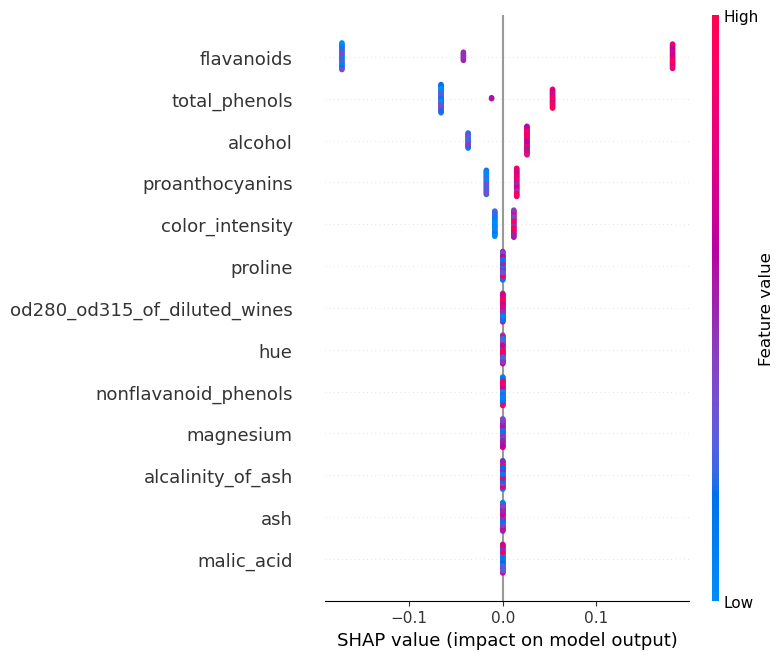

In [26]:
import shap

# Initialize your explainer
explainer = shap.Explainer(pipeline.named_steps['classifier'])

# Compute SHAP values
shap_values = explainer.shap_values(X_dev)

# Summarize the SHAP values in a plot
shap.summary_plot(shap_values[0], X_dev)


In [29]:
import numpy as np
import pandas as pd

# Calculer les statistiques descriptives de X_dev
stats_describe = X_dev.describe()

# Fonction pour calculer les pourcentages réels couverts
def calculate_real_percentage_or_value(min_val, max_val, feature, stats):
    if min_val == max_val:  # Si min et max sont égaux, retourner la valeur directement
        return str(min_val)
    else:
        total_range = stats.at['max', feature] - stats.at['min', feature]
        if total_range > 0:
            min_percentage = ((min_val - stats.at['min', feature]) / total_range) * 100
            max_percentage = ((max_val - stats.at['min', feature]) / total_range) * 100
            return f"{min_percentage:.2f}%-{max_percentage:.2f}%"
        else:
            return "N/A"
# Initialiser une liste globale pour collecter les données de toutes les classes
all_data = []

# Boucle sur toutes les classes disponibles dans `shap_values`
for classe in range(len(shap_values)):
    indices_of_class = [i for i, label in enumerate(y_dev) if label == classe]
    global_mean_abs_shap = np.mean(np.abs(shap_values[classe][indices_of_class, :]), axis=0).sum()
    data = []
    
    for i, feature_name in enumerate(X_dev.columns):
        positive_indices = [idx for idx in indices_of_class if shap_values[classe][idx, i] > 0]
        negative_indices = [idx for idx in indices_of_class if shap_values[classe][idx, i] < 0]
        original_values_positive = X_dev.iloc[positive_indices, i]
        original_values_negative = X_dev.iloc[negative_indices, i]
        positive_impact_percentage = len(positive_indices) / len(shap_values[classe][indices_of_class, i]) * 100
        mean_shap_values = np.mean(shap_values[classe][indices_of_class, i], axis=0)
        # Gérer "Rule For" et "Rule Against" pour afficher une valeur unique si min == max
        rule_for = f"{original_values_positive.min()}" if original_values_positive.min() == original_values_positive.max() else f"{original_values_positive.min()} and < {original_values_positive.max()}"
        rule_against = f"{original_values_negative.min()}" if original_values_negative.min() == original_values_negative.max() else f"{original_values_negative.min()} and < {original_values_negative.max()}"
        importance_sign = "Positive" if mean_shap_values > 0 else "Negative"
        data.append({
            'Class': classe,
            'Feature': feature_name,
            'Rule For': rule_for,
            'Rule Against': rule_against,
            'Couverture Pour': positive_impact_percentage,
            'Couverture Contre': 100-positive_impact_percentage,
            'Intervalle Pour': calculate_real_percentage_or_value(original_values_positive.min(), original_values_positive.max(), feature_name, stats_describe),
            'Intervalle Contre': calculate_real_percentage_or_value(original_values_negative.min(), original_values_negative.max(), feature_name, stats_describe),
            'Importance': round((np.abs(shap_values[classe][:, i]).mean() / np.sum(np.abs(shap_values[classe]).mean(axis=0))) * 100, 2),
            'Signe Importance': importance_sign
        })
    
    all_data.extend(data)

# Créer le DataFrame final à partir de la liste globale
results_df = pd.DataFrame(all_data).sort_values('Importance', ascending=False).query('`Couverture Pour` > 0')
results_df.query('Class == 0 and `Rule For` != "N/A"')# and Importance > 1



,Class,Feature,Rule For,Rule Against,Couverture Pour,Couverture Contre,Intervalle Pour,Intervalle Contre,Importance,Signe Importance
6,0,flavanoids,2.37 and < 3.93,nan and < nan,100.000000,0.000000,41.21%-75.05%,nan%-nan%,57.62,Positive
5,0,total_phenols,2.48 and < 3.4,2.4 and < 2.45,83.333333,16.666667,56.12%-94.94%,52.74%-54.85%,21.72,Positive
0,0,alcohol,12.85 and < 14.38,nan and < nan,100.000000,0.000000,45.74%-100.00%,nan%-nan%,10.96,Positive
8,0,proanthocyanins,1.46 and < 2.96,1.25 and < 1.37,88.888889,11.111111,41.18%-100.00%,32.94%-37.65%,5.93,Positive
9,0,color_intensity,4.9 and < 8.7,3.7 and < 4.5,72.222222,27.777778,32.48%-76.87%,18.46%-27.80%,3.77,Positive


In [30]:
results_df.query('Class == 1 and `Rule For` != "N/A"')

,Class,Feature,Rule For,Rule Against,Couverture Pour,Couverture Contre,Intervalle Pour,Intervalle Contre,Importance,Signe Importance
22,1,color_intensity,2.12 and < 4.6,5.3 and < 6.0,90.476190,9.523810,0.00%-28.97%,37.15%-45.33%,28.70,Positive
19,1,flavanoids,1.09 and < 2.26,2.45 and < 5.08,80.952381,19.047619,13.45%-38.83%,42.95%-100.00%,28.55,Positive
13,1,alcohol,11.56 and < 12.77,13.03 and < 13.67,80.952381,19.047619,0.00%-42.91%,52.13%-74.82%,27.65,Positive
18,1,total_phenols,1.38 and < 2.45,2.53 and < 3.52,71.428571,28.571429,9.70%-54.85%,58.23%-100.00%,7.60,Positive
21,1,proanthocyanins,1.46 and < 2.35,0.41 and < 1.42,42.857143,57.142857,41.18%-76.08%,0.00%-39.61%,7.50,Negative


In [31]:
results_df.query('Class == 2 and `Rule For` != "N/A"')

,Class,Feature,Rule For,Rule Against,Couverture Pour,Couverture Contre,Intervalle Pour,Intervalle Contre,Importance,Signe Importance
32,2,flavanoids,0.47 and < 1.25,nan and < nan,100.000000,0.000000,0.00%-16.92%,nan%-nan%,50.89,Positive
31,2,total_phenols,1.15 and < 2.05,nan and < nan,100.000000,0.000000,0.00%-37.97%,nan%-nan%,21.08,Positive
35,2,color_intensity,5.45 and < 10.68,4.1 and < 4.4,86.666667,13.333333,38.90%-100.00%,23.13%-26.64%,12.82,Positive
34,2,proanthocyanins,0.83 and < 1.35,1.46 and < 1.56,73.333333,26.666667,16.47%-36.86%,41.18%-45.10%,11.52,Positive
26,2,alcohol,12.81 and < 14.13,12.25 and < 12.51,86.666667,13.333333,44.33%-91.13%,24.47%-33.69%,3.69,Positive


In [32]:
import numpy as np
import pandas as pd

# Supposons que X_dev est un DataFrame et y_dev est un array ou une Series contenant les vraies classes

# Prédictions du modèle sur le jeu de données de développement
predictions = pipeline.predict(X_dev)

# Identifier les indices des instances mal classées
misclassified_indices = np.where(y_dev != predictions)[0]

# Extraire les instances mal classées de X_dev en utilisant les indices
misclassified_samples = X_dev.iloc[misclassified_indices]

# Créer un DataFrame contenant les vraies classes et les classes prédites pour les instances mal classées
misclassified_df = pd.DataFrame({
    'True Class': y_dev[misclassified_indices],
    'Predicted Class': predictions[misclassified_indices]
})

# Ajouter les caractéristiques des instances mal classées à partir de X_dev
misclassified_df = pd.concat([misclassified_samples.reset_index(drop=True), misclassified_df.reset_index(drop=True)], axis=1)


# Afficher le DataFrame des instances mal classées
misclassified_df


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280_od315_of_diluted_wines,proline,True Class,Predicted Class
0,11.56,2.05,3.23,28.5,119.0,3.18,5.08,0.47,1.87,6.0,0.93,3.69,465.0,1,0
1,12.37,1.07,2.10,18.5,88.0,3.52,3.75,0.24,1.95,4.5,1.04,2.77,660.0,1,0
2,13.67,1.25,1.92,18.0,94.0,2.10,1.79,0.32,0.73,3.8,1.23,2.46,630.0,1,2
3,13.11,1.01,1.70,15.0,78.0,2.98,3.18,0.26,2.28,5.3,1.12,3.18,502.0,1,0


In [34]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
class MyNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.parameters = {}
        for cls in self.classes:
            X_cls = X[y == cls]
            self.parameters[cls] = {
                'mean': X_cls.mean(axis=0),
                'var': np.var(X_cls, axis=0, ddof=1),
                'prior': np.log(len(X_cls) / len(X))  # Stocker le log des priors
            }

    def _calculate_log_proba(self, X, cls):
        eps = 1e-6  # Pour éviter la division par zéro
        mean = self.parameters[cls]['mean']
        var = self.parameters[cls]['var']
        prior_log = self.parameters[cls]['prior']
        
        # Calcul du terme qui ne dépend que de var + eps, une fois par classe
        sum_log_var = np.sum(np.log(2. * np.pi * var + eps))
        # Calcul du logarithme de la probabilité conditionnelle pour chaque caractéristique
        log_proba = -0.5 * sum_log_var - 0.5 * np.sum(((X - mean) ** 2) / (var + eps), axis=1)
        return log_proba + prior_log

    def predict_log_proba(self, X):
        log_probas = np.array([self._calculate_log_proba(X, cls) for cls in self.classes]).T
        # Normalisation pour obtenir des log-probabilités, améliorant la stabilité numérique
        a_max = np.max(log_probas, axis=1, keepdims=True)
        log_probas -= a_max
        log_sum_exp = a_max + np.log(np.sum(np.exp(log_probas), axis=1, keepdims=True))
        return log_probas - log_sum_exp

    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))
    
    def predict(self, X):
        log_probas = self.predict_log_proba(X)
        return self.classes[np.argmax(log_probas, axis=1)]
    
    def predict_feature_proba(self, X):
        # Cette méthode n'était pas définie précédemment. Assurez-vous qu'elle soit bien incluse dans la classe.
        feature_probas = np.zeros((X.shape[0], X.shape[1], len(self.classes)))
        for i, cls in enumerate(self.classes):
            eps = 1e-6
            mean = self.parameters[cls]['mean']
            var = self.parameters[cls]['var']
            # Calcul des probabilités conditionnelles pour chaque caractéristique
            numerator = np.exp(-((X - mean) ** 2) / (2 * var + eps))
            denominator = np.sqrt(2 * np.pi * var + eps)
            feature_probas[:, :, i] = numerator / denominator
        # Normalisation des probabilités pour chaque caractéristique par classe
        sum_over_classes = np.sum(feature_probas, axis=2, keepdims=True)
        feature_probas /= sum_over_classes
        return feature_probas
    def calculate_woe(self, X):
            feature_probas = self.predict_feature_proba(X)  # shape: (instances, features, classes)
            woe_values = np.zeros_like(feature_probas)

            for cls_idx, cls in enumerate(self.classes):
                # Calculate P(f | not h) for the current class
                p_f_not_h = np.sum(feature_probas[:, :, :], axis=2) - feature_probas[:, :, cls_idx]
                p_f_not_h /= (len(self.classes) - 1)  # Average over all classes except the current one

                # Avoid division by zero
                p_f_not_h = np.clip(p_f_not_h, 1e-9, 1-1e-9)
                p_f_h = np.clip(feature_probas[:, :, cls_idx], 1e-9, 1-1e-9)

                # Calculate WoE
                woe_values[:, :, cls_idx] = np.log(p_f_h / p_f_not_h)

            return woe_values

# Création et entraînement du modèle
nb_model = MyNaiveBayes()
nb_model.fit(X_train, y_train)

# Calcul des probabilités conditionnelles des caractéristiques pour chaque classe
# Attention : Assurez-vous que la méthode `predict_feature_proba` a été ajoutée à la classe `MyNaiveBayes`
feature_probas = nb_model.predict_feature_proba(X_dev)
feature_woe = nb_model.calculate_woe(X_dev)
# feature_probas est maintenant le tableau des probabilités conditionnelles demandé
# Il a une forme de (nombre d'instances, nombre de caractéristiques, nombre de classes)
y_pred = nb_model.predict(X_dev)
accuracy = accuracy_score(y_dev, y_pred)

model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_dev)
accuracy2 = accuracy_score(y_dev, y_pred)
all_data = []

# Boucle sur toutes les classes disponibles dans `feature_woe`
# Ici, 'classe' indexe la dernière dimension de 'feature_woe'
for classe in range(feature_woe.shape[2]):
    data = []

    for i, feature_name in enumerate(X_dev.columns):
        # Extraction de la colonne de valeurs pour la caractéristique actuelle et la classe spécifique
        woe_values_for_feature_and_class = feature_woe[:, i, classe]
        
        # Calcul de la valeur moyenne de WoE pour la caractéristique et la classe
        mean_woe_value = np.mean(woe_values_for_feature_and_class)
        
        
        data.append({
            'Class': classe,
            'Feature': feature_name, 
            'Mean_WoE_Value': round(mean_woe_value, 2),
        })

    all_data.extend(data)

# Création du DataFrame à partir de la liste globale
results_woe = pd.DataFrame(all_data).sort_values(by=['Class', 'Mean_WoE_Value'], ascending=[True, False])


# Affichage des résultats
results_woe.query('Class==1 and Mean_WoE_Value>0')

,Class,Feature,Mean_WoE_Value
23,1,hue,0.03


In [35]:
results_woe.query('Class==1 and Mean_WoE_Value<0').sort_values(by='Mean_WoE_Value')

,Class,Feature,Mean_WoE_Value
22,1,color_intensity,-4.10
25,1,proline,-1.59
13,1,alcohol,-1.38
24,1,od280_od315_of_diluted_wines,-0.45
14,1,malic_acid,-0.20
17,1,magnesium,-0.13
20,1,nonflavanoid_phenols,-0.13
16,1,alcalinity_of_ash,-0.03
18,1,total_phenols,-0.03
15,1,ash,-0.01


In [36]:
accuracy

1.0

In [37]:
accuracy2

1.0